# EDA z uwzględnieniem czynnika przestrzennego

Poniższą analizę wykonano dla danych dotyczących zanieczyszczenia powietrza, pochodzących z bazy WHO. Zbiór danych zawiera pomiary z różnych lokalizacji na świecie. Dane zawierają następujące informacje:
*   **WHO Region**: Nazwa regionu, w którym znajduje się lokalizacja.
ISO3

*  **WHO Country Name**: Nazwa kraju, w którym znajduje się lokalizacja.
*   **City or Locality**: Nazwa lokalizacji, w którym
*   **Measurement Year**: Rok pomiaru.
*   **PM2.5 (μg/m3)**: Stężenie pyłów PM2.5.
*   **PM10 (μg/m3)**: Stężenie pyłów PM10.
*   **NO2 (μg/m3)**: Stężenie dwutlenku azotu (NO2)
*  **PM25 temporal coverage (%)**: Pokrycie czasowe danych dotyczących pyłów PM2.5 (%).
*    **PM10 temporal coverage (%)**: Pokrycie czasowe danych dotyczących pyłów PM10 (%).
*    **NO2 temporal coverage (%)**: Pokrycie czasowe danych dotyczących dwutlenku azotu (%).
*    **Reference**: Odwołanie do źródła danych.
*    **Number and type of monitoring stations**: Liczba i typ stacji monitorujących.
*    **Version of the database**: Wersja bazy danych.
*    **Status**: Status danych.

In [3]:
import numpy as np
import pandas as pd
# !pip install itables
# !pip install geopy
import itables as it
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

In [4]:
# Stworzenie mapy kolorystycznej
red = '#EE0000'
orange = '#EE7700'
yellow = '#EEEE00'
celadon = '#77EE00'
green = '#00EE00'
cmap_colors = [green, celadon, yellow, orange, red]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', cmap_colors)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Wczytanie danych z pliku

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/UM/WHO_powietrze/who_aap_2021_v9_11august2022.xlsx"
data = pd.read_excel(path, sheet_name="AAP_2022_city_v9")

In [ ]:
it.init_notebook_mode(all_interactive=True, connected=True)

In [ ]:
it.show(data)

Biblioteka ITables okazała się pomocna przy wyświetlaniu danych w przystępnej formie. Umożliwia przeglądanie wybranej ilości obserwacji na stronie, wyszukiwanie fraz oraz sortowanie po wszystkich kolumnach. Jednakże w przypadku tak dużego zbioru nie wszystkie dane są wyświetlane, co może prowadzić do mylnych wniosków. Np. podczas sortowania tabeli względem lat, pomiary zaczynają się od roku 2010, ponieważ wcześniejsze pomiary zostały pominięte podczas downsamplingu.

# Geokodowanie miast

Aby każdej lokalizacji przypisać odpowiadające jej koordynaty, skorzystano z biblioteki geopy oraz opencage. Ten sposób był względnie skuteczny, ale też bardzo czasochłonny.

In [ ]:
geolocator = Nominatim(user_agent="my_geocoder")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

unique_cities = pd.DataFrame()
unique_cities['Full Address'] = (data['City or Locality'] + ", " + data['WHO Country Name']).drop_duplicates()
geolocator = Nominatim(user_agent="my_geocoder")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
unique_cities['Location'] = unique_cities['Full Address'].apply(geocode)

unique_cities['Coordinates'] = unique_cities['Location'].apply(lambda loc: (loc.latitude, loc.longitude) if loc else None)
unique_cities[['Latitude', 'Longitude']] = unique_cities['Coordinates'].apply(pd.Series)


In [ ]:
cities_path = '/content/drive/MyDrive/Colab Notebooks/UM/WHO_powietrze/unique_cities.csv'
unique_cities = pd.read_csv(cities_path)
# unique_cities.rename(columns={'Longtitude': 'Longitude'}, inplace=True)
it.show(unique_cities)
# unique_cities.to_csv(cities_path, index=False)

In [ ]:
missing_locations = unique_cities.loc[unique_cities['Location'].isna()]
# it.show(missing_locations)

In [ ]:
# !pip install opencage
from opencage.geocoder import OpenCageGeocode

In [ ]:
# Uzupełnienie brakujących współrzędnych
api_key = '70921799b6a540c6b065b2ece3e1f920'
geocoder = OpenCageGeocode(api_key)

def geocode_place(place):
    try:
        result = geocoder.geocode(place)
        if result and len(result):
            latitude = result[0]['geometry']['lat']
            longitude = result[0]['geometry']['lng']
            return latitude, longitude
        else:
            return None, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

for index, row in missing_locations.iterrows():
    place = row['Full Address']
    latitude, longitude = geocode_place(place)
    missing_locations.at[index, 'Coordinates'] = (latitude, longitude)
    missing_locations.at[index, 'Latitude'] = latitude
    missing_locations.at[index, 'Longitude'] = longitude

it.show(missing_locations)

In [ ]:
unique_cities_updated = unique_cities.merge(missing_locations,
                                             on='Full Address', how='left', suffixes=('', '_missing'))

unique_cities_updated['Latitude'].fillna(unique_cities_updated['Latitude_missing'], inplace=True)
unique_cities_updated['Longitude'].fillna(unique_cities_updated['Longitude_missing'], inplace=True)

unique_cities_updated.drop(columns=['Location_missing', 'Coordinates_missing', 'Latitude_missing', 'Longitude_missing'], inplace=True)
# unique_cities_updated.to_csv('/content/drive/MyDrive/Colab Notebooks/UM/WHO_powietrze/updated_unique_cities.csv', index=False)

In [ ]:
it.show(unique_cities_updated)

In [ ]:
missing_locations = unique_cities_updated.loc[unique_cities_updated['Latitude'].isna()]
it.show(missing_locations)

In [ ]:
cities_updated_path = '/content/drive/MyDrive/Colab Notebooks/UM/WHO_powietrze/updated_unique_cities.csv'
unique_cities_updated = pd.read_csv(cities_updated_path)

# Ręczne ustawienie wartości dla miejsc nierozpoznanych (https://geocode.xyz/)
manual_locations = {
    'Danlong Road, China': (30.1017, 120.8446),
    'Xiongguan West Road, China': (24.20381,102.80902),
    'Yuma Road, China': (29.53869,106.64857),
    'Nelson Airshed A, New Zealand': (-41.29527,173.23087),
    'San Juan-Carolina-Caguas (Pr), United States of America': (26.23841,-98.13119)
}

for place, coords in manual_locations.items():
    unique_cities_updated.loc[unique_cities_updated['Full Address'] == place,
                              ['Latitude', 'Longitude']] = coords
unique_cities_updated['Coordinates'] = unique_cities_updated.apply(lambda row: (row['Latitude'], row['Longitude']), axis=1)

In [ ]:
# unique_cities_updated.to_csv('/content/drive/MyDrive/Colab Notebooks/UM/WHO_powietrze/updated_unique_cities.csv', index=False)

In [ ]:
cities_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UM/WHO_powietrze/updated_unique_cities.csv')
geo_data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/UM/WHO_powietrze/who_aap_2021_v9_11august2022.xlsx', sheet_name="AAP_2022_city_v9")

In [ ]:
cities_data[['City', 'Country']] = cities_data['Full Address'].str.rsplit(', ', n=1, expand=True)
merged_data = pd.merge(geo_data, cities_data, left_on=["WHO Country Name", "City or Locality"], right_on=["Country", "City"], how="left")

merged_data = merged_data.drop(columns=['Full Address', 'Location', 'Coordinates', 'City', 'Country'])
it.show(merged_data)
# merged_data.to_excel('/content/drive/MyDrive/Colab Notebooks/UM/WHO_powietrze/who_data.xlsx', index=False)

# Wstępna analiza zbioru danych i preprocessing

In [128]:
data = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/UM/WHO_powietrze/who_data.xlsx")

In [129]:
# podstawowe statystyki opisowe
data.describe()

Measurement Year  PM2.5 (μg/m3)  PM10 (μg/m3)   NO2 (μg/m3)  \
count      32191.000000   15048.000000  21109.000000  22200.000000   
mean        2015.579354      22.920320     30.533252     20.619336   
std            2.752654      17.925906     29.312756     12.133388   
min         2000.000000       0.010000      1.040000      0.000000   
25%         2014.000000      10.350000     16.980000     12.000000   
50%         2016.000000      16.000000     22.000000     18.800000   
75%         2018.000000      31.000000     31.300000     27.160000   
max         2021.000000     191.900000    540.000000    210.680000   

       PM25 temporal coverage (%)  PM10 temporal coverage (%)  \
count                 7275.000000                 5381.000000   
mean                    90.794096                   90.583500   
std                     14.872681                   13.816311   
min                      0.000000                    2.568493   
25%                     88.595890                   87.945205   
50%                     97.000000                   96.039000   
75%                     99.000000                   98.938000   
max                    100.000000                  100.000000   

       NO2 temporal coverage (%)  Version of the database  Status  \
count               19890.000000             32191.000000     0.0   
mean                   93.696804              2021.744214     NaN   
std                    10.451751                 1.051897     NaN   
min                     1.923077              2016.000000     NaN   
25%                    93.207763              2022.000000     NaN   
50%                    96.369863              2022.000000     NaN   
75%                    98.926941              2022.000000     NaN   
max                   100.000000              2022.000000     NaN   

           Latitude     Longitude  
count  32191.000000  32191.000000  
mean      38.733023     19.997764  
std       17.653729     58.435954  
min      -53.162569   -159.346352  
25%       34.419843      1.603771  
50%       43.611934     12.019508  
75%       49.191303     35.000494  
max       73.658543    178.442166

W tabeli podstawowych statystyk można zauważyć, że przedział czasowy pomiarów sięga roku 2000. Rozkład tej zmiennej jest nierównomierny - średnia przypada na rok 2015, co oznacza, że początkowo tych pomiarów było znacznie mniej niż w późniejszym czasie.

In [130]:
it.show(data.groupby(['Measurement Year']).size())

Przed rokiem 2010 liczba wykonywanych pomiarów była bardzo mała, dlatego te obserwacje można usunąć.

In [131]:
data = data[data['Measurement Year'] >= 2010]
it.show(data.groupby(['Measurement Year']).size())

W pliku pojawia się dużo brakujących pomiarów. Aby zobrazować zależności między zmiennymi, wykonano macierz korelacji.

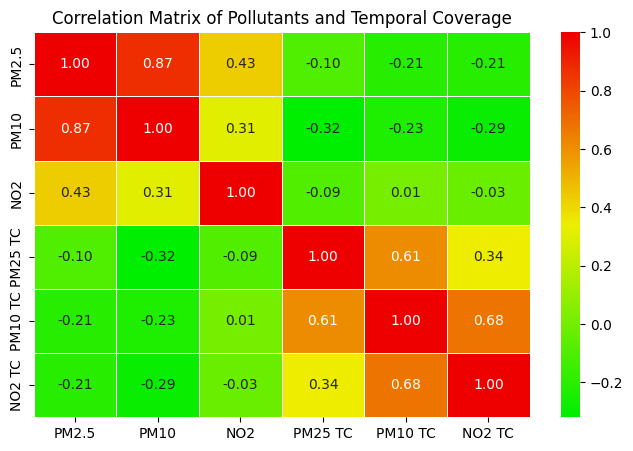

In [132]:
plt.figure(figsize=(8, 5))
df = data.copy()
df = df[['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)', 'PM25 temporal coverage (%)', 'PM10 temporal coverage (%)',
          'NO2 temporal coverage (%)']]
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, fmt=".2f", linewidths=0.5,
            xticklabels=['PM2.5', 'PM10', 'NO2', 'PM25 TC', 'PM10 TC', 'NO2 TC'],
            yticklabels=['PM2.5', 'PM10', 'NO2', 'PM25 TC', 'PM10 TC', 'NO2 TC'])
plt.title('Correlation Matrix of Pollutants and Temporal Coverage')
plt.show()

Największa korelacja występuje między stężeniem PM2.5 a PM10, co wynika z faktu, że pył PM2.5 jest uwzględniany podczas pomiarów PM10. Zdecydowano się na uzupełnienie brakujących wartości PM poprzez zastosowanie modelu regresji liniowej.

In [133]:
# Usunięcie obserwacji bez stężenia PM2.5 oraz PM10
data = data[data['PM2.5 (μg/m3)'].notnull() | data['PM10 (μg/m3)'].notnull()]

# Stworzenie zestawu danych treningowych
training_data = data[data['PM2.5 (μg/m3)'].notnull() & data['PM10 (μg/m3)'].notnull()]
training_data = training_data[['PM2.5 (μg/m3)', 'PM10 (μg/m3)']]

data_pm25_missing = data[data['PM2.5 (μg/m3)'].isnull()]
data_pm10_missing = data[data['PM10 (μg/m3)'].isnull()]

data_pm25_missing = data_pm25_missing[['PM2.5 (μg/m3)', 'PM10 (μg/m3)']]
data_pm10_missing = data_pm10_missing[['PM2.5 (μg/m3)', 'PM10 (μg/m3)']]

In [134]:
def fill_missing_data(df_train, df_missing, feature_to_predict):
    X_train = df_train.drop(columns=feature_to_predict)
    y_train = df_train[feature_to_predict]

    model = LinearRegression()
    model.fit(X_train, y_train)

    X_missing = df_missing.drop(columns=feature_to_predict)
    y_pred = model.predict(X_missing)

    df_filled = df_missing.copy()
    df_filled[feature_to_predict] = y_pred
    return df_filled


data_pm25_filled = fill_missing_data(training_data, data_pm25_missing, 'PM2.5 (μg/m3)')
data_pm10_filled = fill_missing_data(training_data, data_pm10_missing, 'PM10 (μg/m3)')
data_filled = pd.concat([data_pm25_filled, data_pm10_filled]).sort_index()

# it.show(data_filled)

In [135]:
missing_rows = data['PM2.5 (μg/m3)'].isnull() | data['PM10 (μg/m3)'].isnull()
data.loc[missing_rows, ['PM2.5 (μg/m3)', 'PM10 (μg/m3)']] = data_filled.loc[missing_rows, ['PM2.5 (μg/m3)', 'PM10 (μg/m3)']]
it.show(data)

Statystki opisowe pokazują także, że w zbiorze danych znajdują się bardzo małe pomiary zanieczyszczeń.

In [136]:
data[['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']].describe()

PM2.5 (μg/m3)  PM10 (μg/m3)   NO2 (μg/m3)
count   27312.000000   27312.00000  17423.000000
mean       20.355035      37.01154     20.865369
std        15.799469      33.96512     11.877465
min         0.010000       1.04000      0.000000
25%        11.140000      17.23000     12.430000
50%        14.347888      23.75000     19.300000
75%        23.580518      43.01000     27.325000
max       213.427560     540.00000    210.680000

Ze względu na dokładność maszyn pomiarowych zdecydowano się usunąć pomiary poniżej 5 μg/m3, które mogą zafałszowywać zbiór danych.


In [137]:
data_tmp = data[(data['PM2.5 (μg/m3)'].isna() | (data['PM2.5 (μg/m3)'] > 5)) &
            (data['PM10 (μg/m3)'].isna() | (data['PM10 (μg/m3)'] > 5)) &
            (data['NO2 (μg/m3)'].isna() | (data['NO2 (μg/m3)'] > 5))]

In [139]:
data_tmp[['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']].describe()
# data_tmp.to_excel('/content/drive/MyDrive/Colab Notebooks/UM/WHO_powietrze/who_data_filled.xlsx', index=False)

# Aplikacja Streamlit


Stworzono interaktywną aplikację do Eksploracyjnej Analizy Danych za pomocą biblioteki Streamlit. Aplikacja znajduje się wraz z plikiem *who_data_filled.xlsx* na platformie GitHub: **https://github.com/icetkier/WHO_EDA**. Poniższe wykresy i mapy to zrzuty ekranu z tej aplikacji.

Aplikacja zawiera trzy zakładki: analizę dla regionów, państw oraz miast. Zależnie od stopnia generalizacji dostępne są filtry dla danych wyświetlanych na mapie: rok, region, państwo, zmienna (stężenie PM2.5, PM10 lub NO2), liczba lokalizacji oraz metoda sortowania (najbardziej/najmniej zanieczoszczone lokalizacje). Oprócz mapy wyświetlane są także podstawowe statystyki, histogramy, macierze korelacji, pairploty oraz boxploty.

In [ ]:
# Uruchomienie aplikacji w terminalu
# streamlit run WHO_EDA.py

Należy wspomnieć, że niektóre opisy lokalizacji dostarczone przez WHO były niedokładne, co skutkowało przypisaniem im niewłaściwych współrzędnych geograficznych podczas geokodowania. W wyniku błędnego przypisania koordynatów na mapie dla analizy miast pojawiają się niepoprawne oznaczenia, jak np. **Wei Nan, China** w Australii.

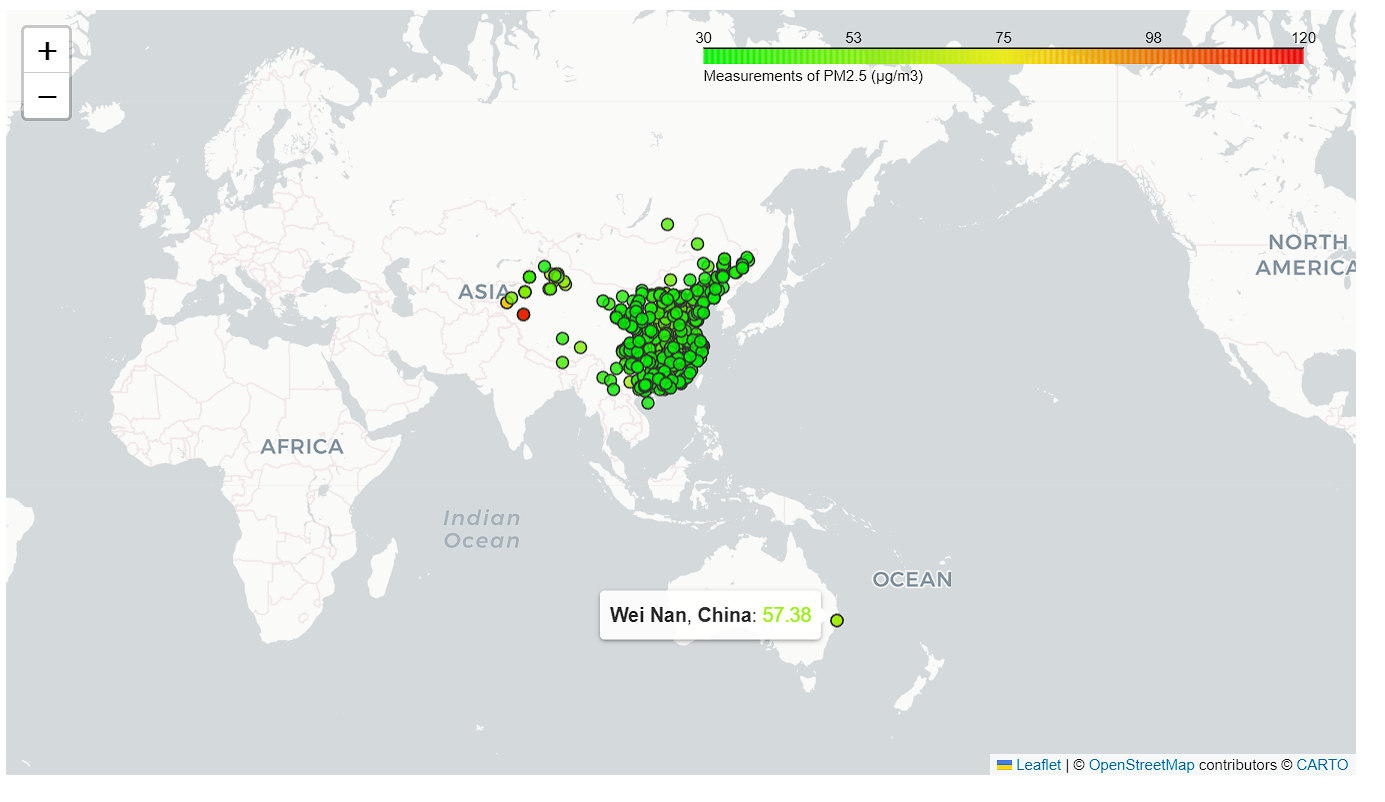

## Analiza dla miast

### Najbardziej zanieczyszczone miasta

Na zdjęciu poniżej przedstawiono 40 najbardziej zanieczyszczonych miast na świecie na podstawie najnowszych danych z każdej lokalizacji. Przedstawione wyniki dotyczą stężenia PM2.5, zmienną tę można oczywiście zmienić w ustawieniach filtracji.

Największe zanieczyszczenie występuje w miastach w Azji Południowej, oraz na Bliskim Wschodzie. Punktem budzącym wątpliwości jest **Bamenda, Cameroon**, ponieważ ostatnie pomiary tam były wykonywane w roku 2012.

Na wykresie punktowym pairplot można z łatwością zaauważyć pomiary stężeń, które zostały uzupełnione za pomocą modelu regresji liniowej.

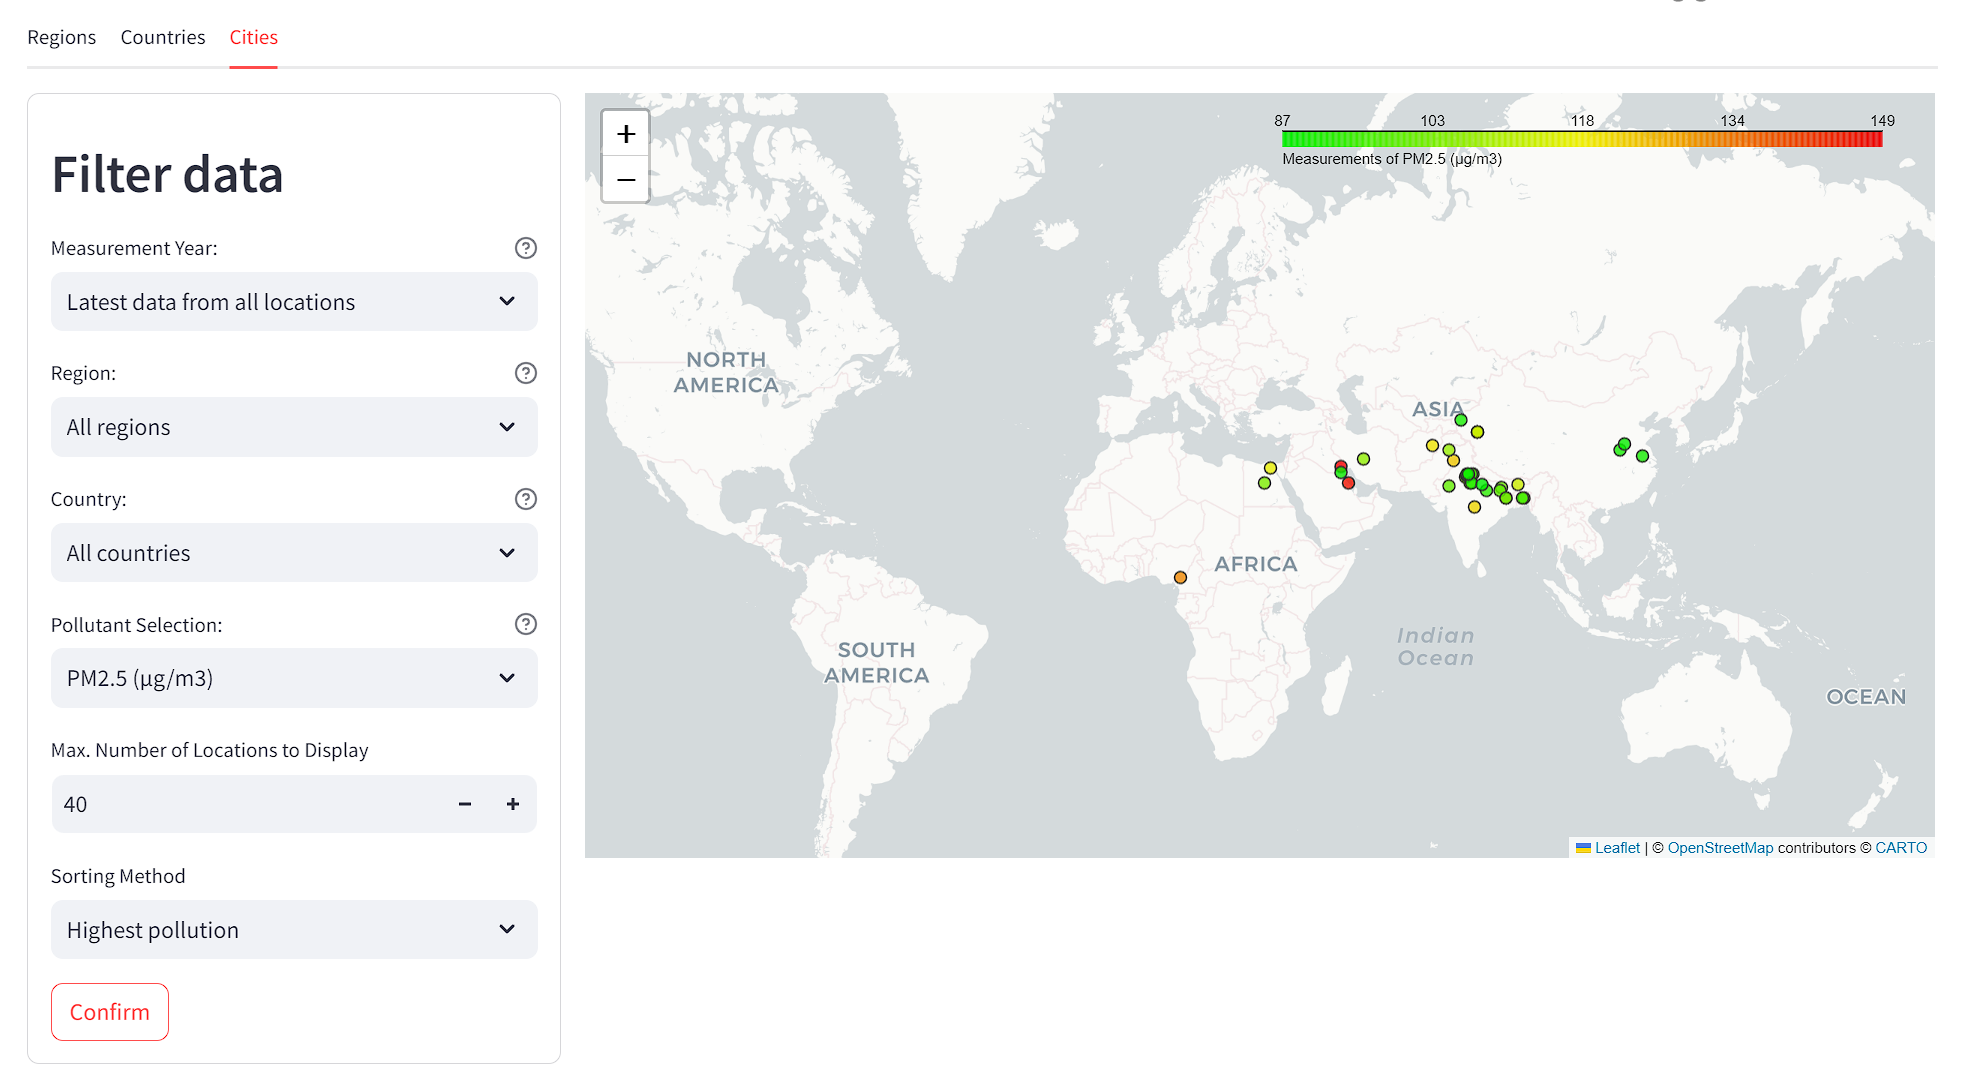

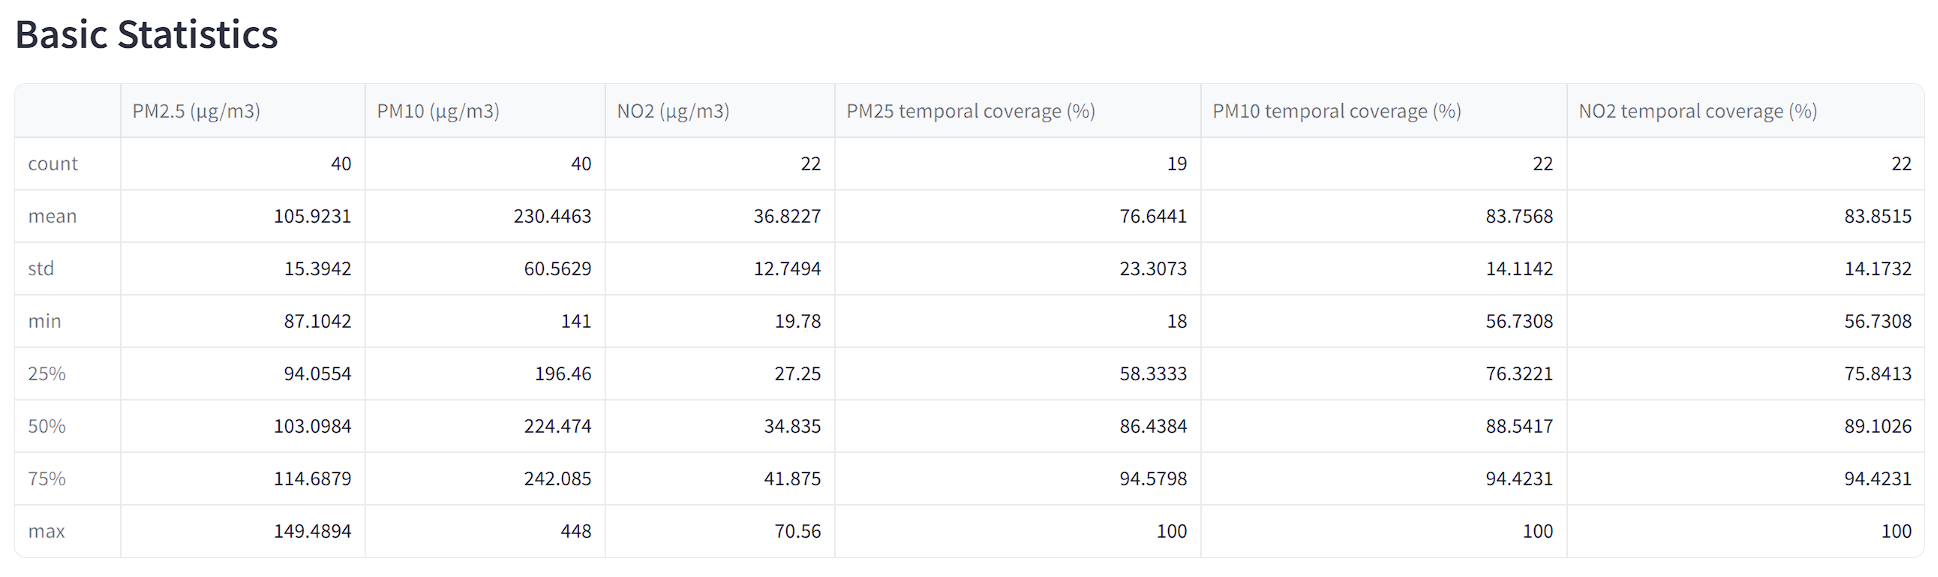

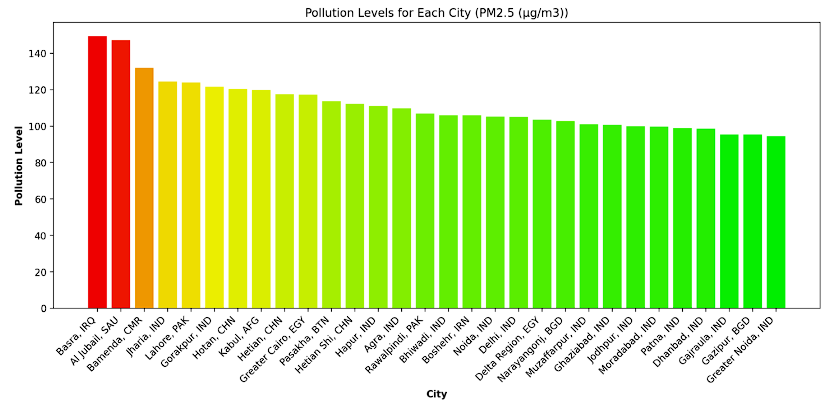

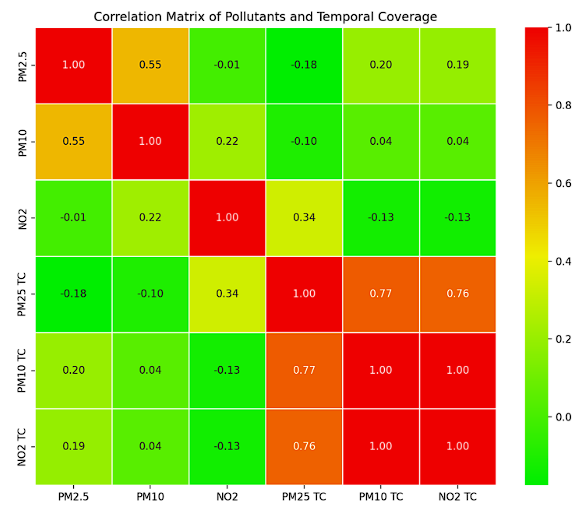

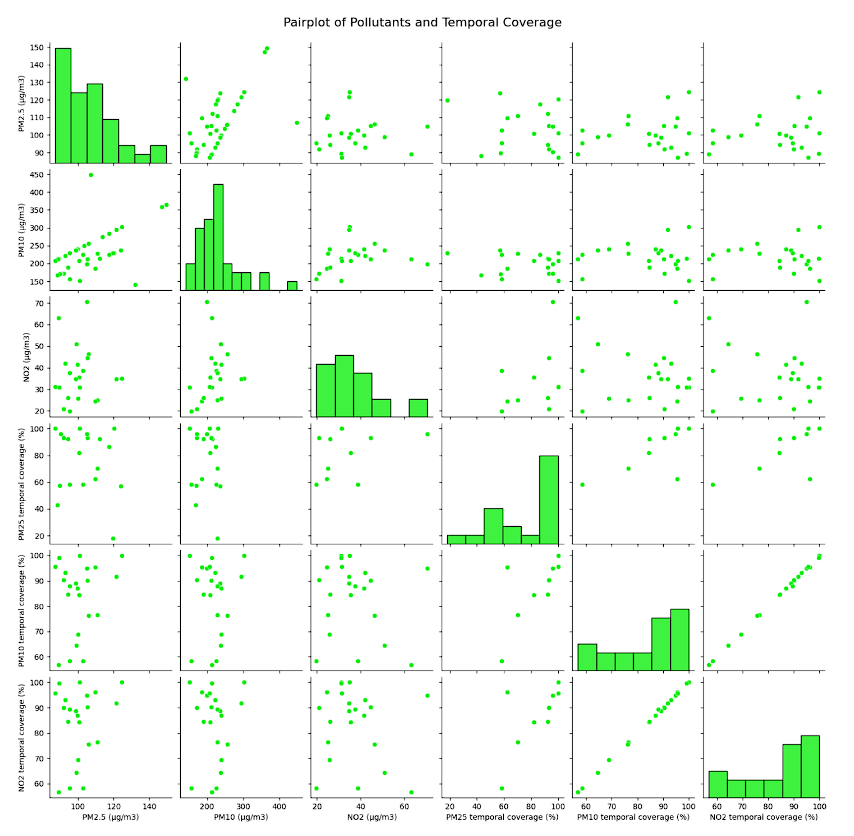

### Najmniej zanieczyszczone miasta

Najmniej zanieczyszczone miasta znajdują się głównie w Europie Zachodniej, Ameryce Północnej oraz w Australii. W przypadku tak małych wartości zależności między zmiennymi są słabo obserwowalne na macierzy korelacji oraz pairplocie.

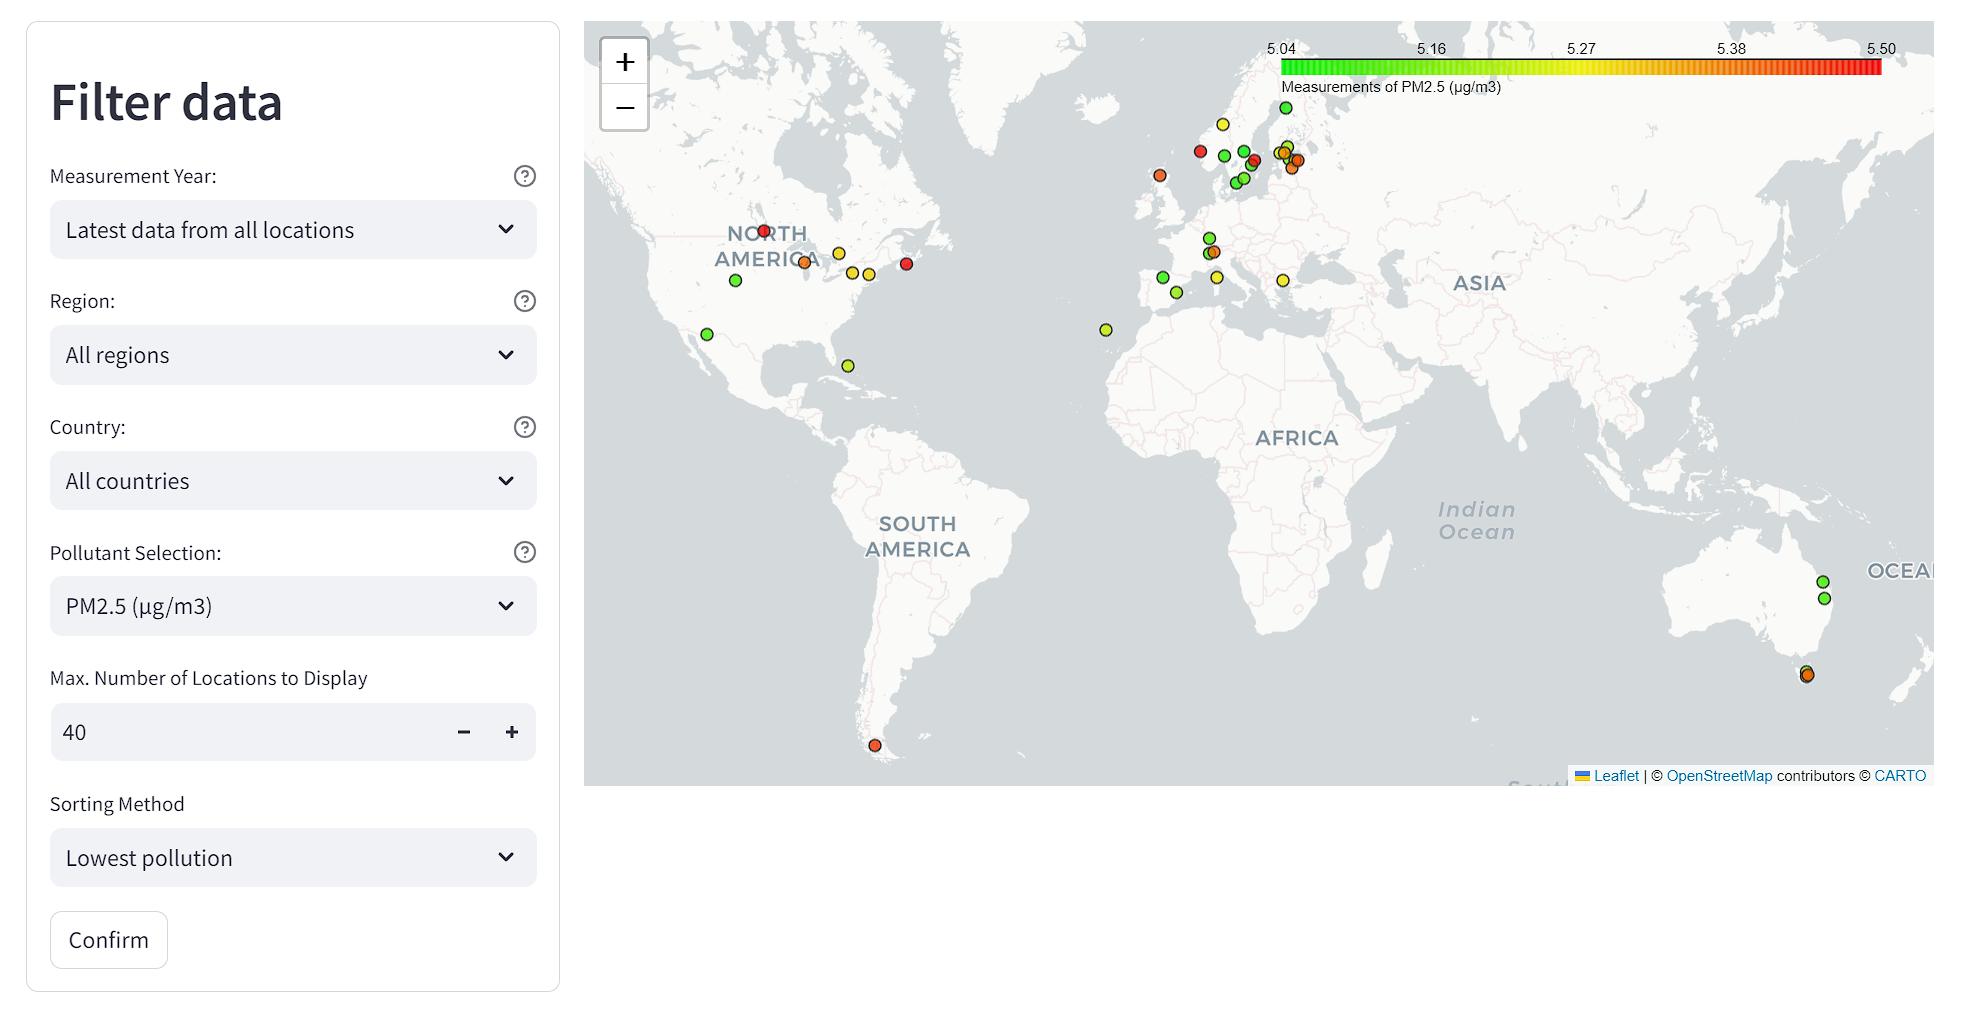

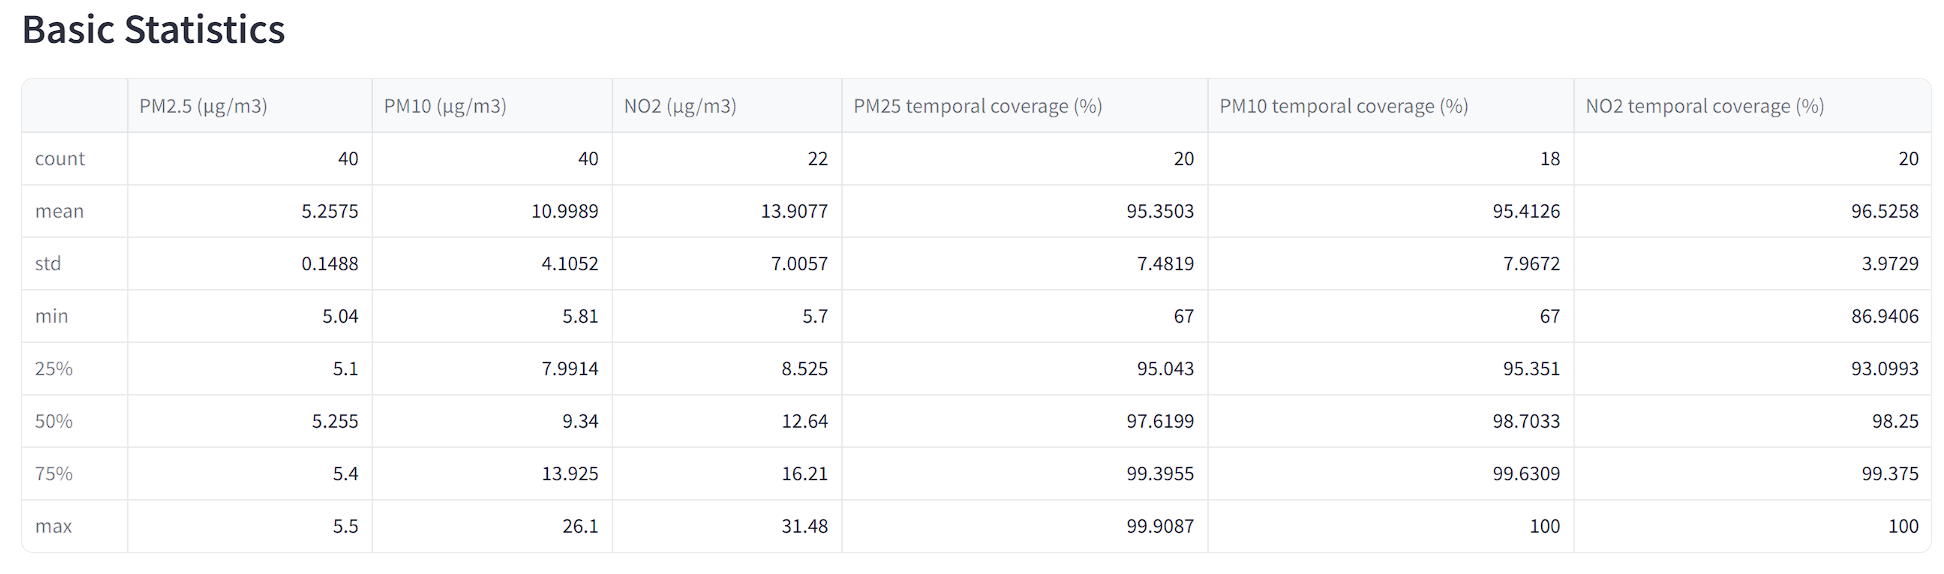

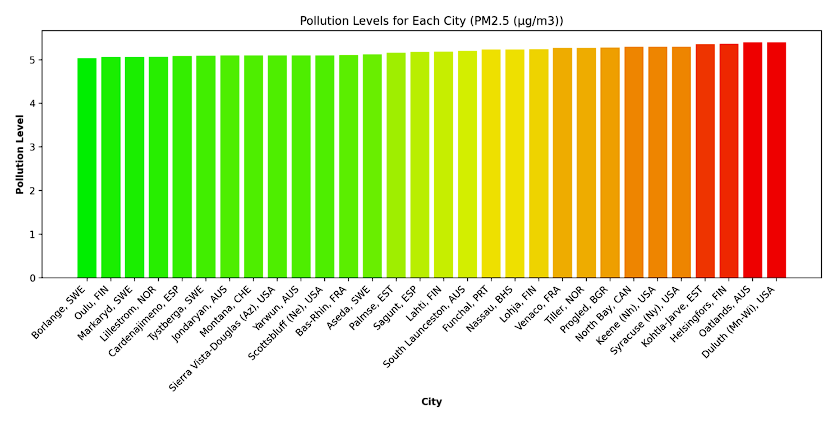

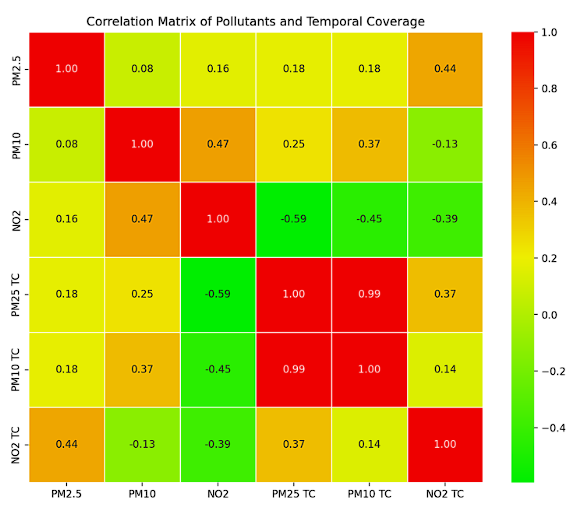

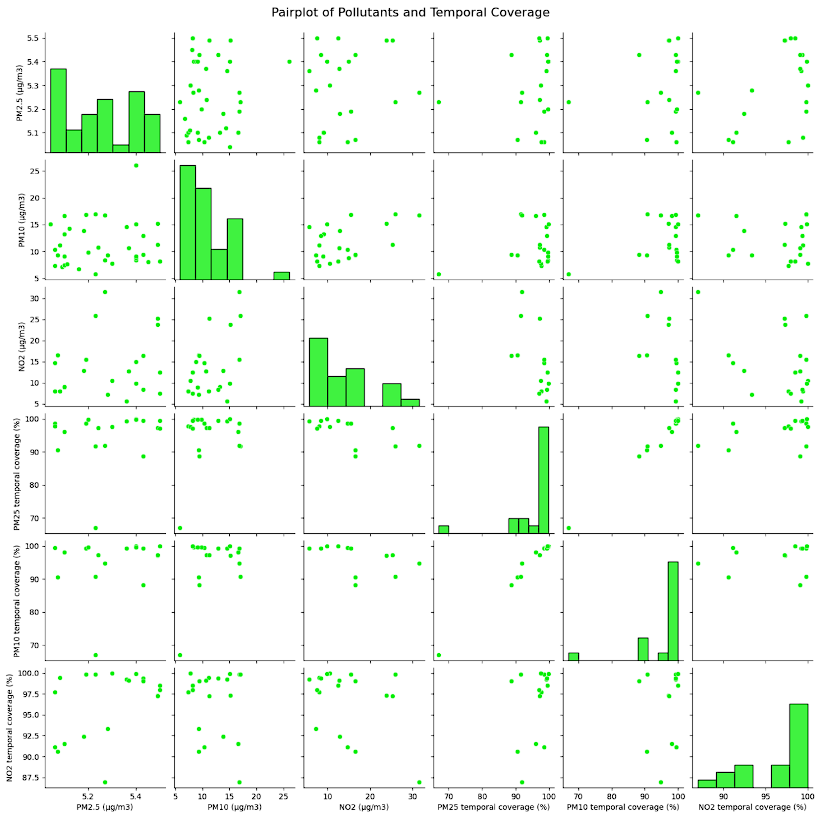

### Analiza najbardziej zanieczyszczonych miast w danym regionie


Oczywiście analizę miast można także przeprowadzić dla wybranego regionu lub kraju. Poniżej przedstawiono 40 najbardziej zanieczyszczonych krajów w regionie Azji Południowo-Wschodniej. Wszystkie skupiają się w północnej części Indii (duże skupisko wokół New Delhi) oraz w sąsiednim Bangladeszu. Tak duże zanieczyszczenie może wynikać z kilku czynników:

*   Rejony te charakteryzują się dużą koncentracją ludności, przemysłu oraz pojazdów, co ma duży wpływ na zanieczyszczenie atmosfery.
*   Ze względu na poziom rozwinięcia tych obszarów, mieszkańcy wykorzystują paliwa kopalne (węgiel, drewno opałowe, olej opałowy) w codziennych czynnościach jak ogrzewanie domów czy gotowanie.
*   Warunki atmosferyczne, takie jak brak wiatru i wysoka wilgotność, mogą sprzyjać gromadzeniu się zanieczyszczeń w powietrzu, ponieważ cząsteczki wody są dobrym nośnikiem pyłów.

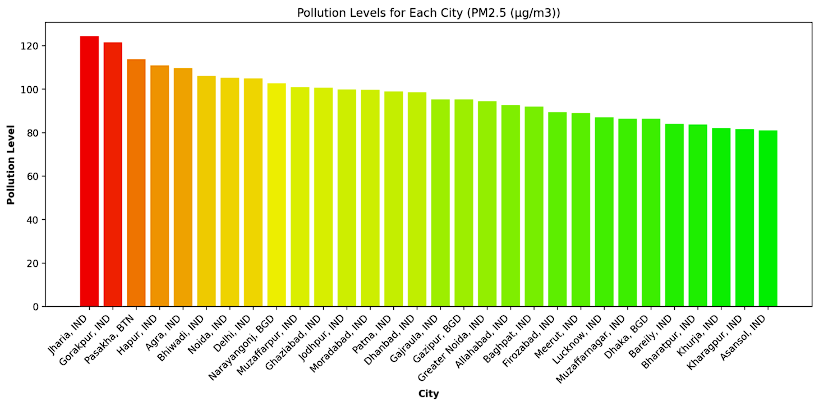

### Analiza najbardziej zanieczyszczonych miast w danym kraju


Wykonano także przykładową analizę miast w obrębie jednego kraju. Poniższa mapa przedstawia 30 najbardziej zanieczyszczonych miast we Włoszech. Większość z nich znajduje się na północy Włoch, co może być związane z różnym podejściem mieszkańców do pracy. Północna część państwa jest dużo lepiej rozwinięta, nastawiona na przemysł i turystykę, te większe skupiska miast mogą zatem zwiększać zanieczyszczenie atmosfery. Z kolei w południowym obszarze Włoch zabudowania są rzadsze, a ludzie żyją wolniej, bliżej natury oraz często sjestują, co może wpływać na niższe stężenie pyłów w powietrzu.



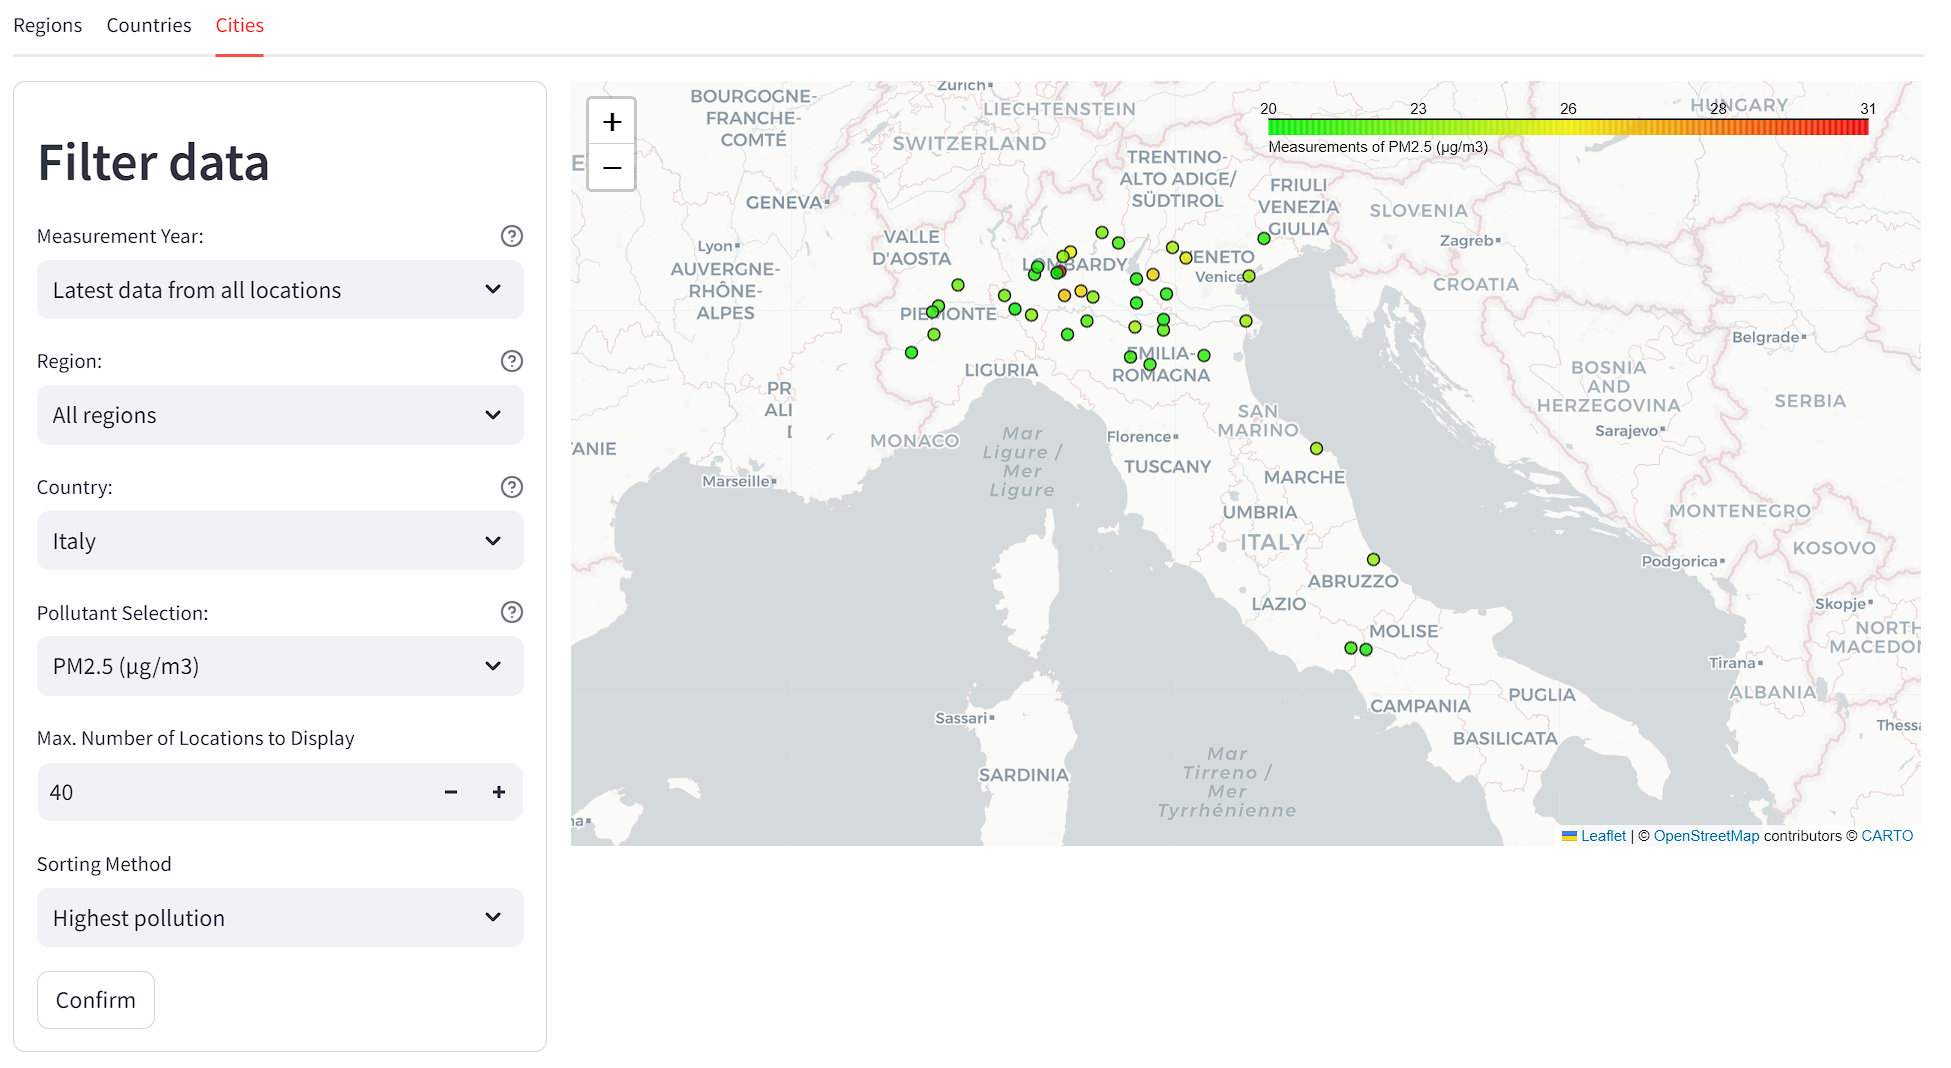

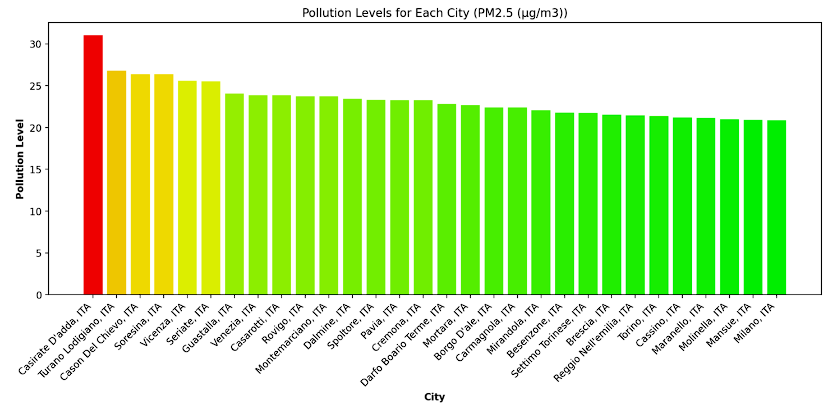

## Analiza dla krajów

Kolejnym stopniem generalizacji jest analiza dla państw. Poniżej przedstawiono wyniki zanieczyszczenia PM2.5 wszystkich krajów, w których kiedykolwiek dokonano pomiarów. Z każdej lokalizacji wzięto najnowszy pomiar, wyniki dla każdego państwa zostały następnie uśrednione.

Najbardziej zanieczyszczonymi krajami okazały się Afganistan, Egipt oraz Arabia Saudyjska. Trzeba jednak sceptycznie spojrzeć na te wyniki za względu na to, że we wszystkich trzech państwach liczba pomiarów nie przekraczała sześciu. Należałoby się zastanowić nad usunięciem państw z małą liczbą obserwacji w dalszej analizie danych.

Przy wykorzystaniu tak dużej liczby pomiarów bardzo dobrze widoczna jest korelacja między PM2.5 a PM10.

Interesujący jest fakt, że w przypadku Indii oraz Chin występuje wiele obserwacji odstających (okrągłe znaczniki na wykresie skrzynkowym). Może to być związane z różnym ukształtowaniem terenu, warunkami aktmosferycznymi oraz stopniem urbanizacji terenu.  

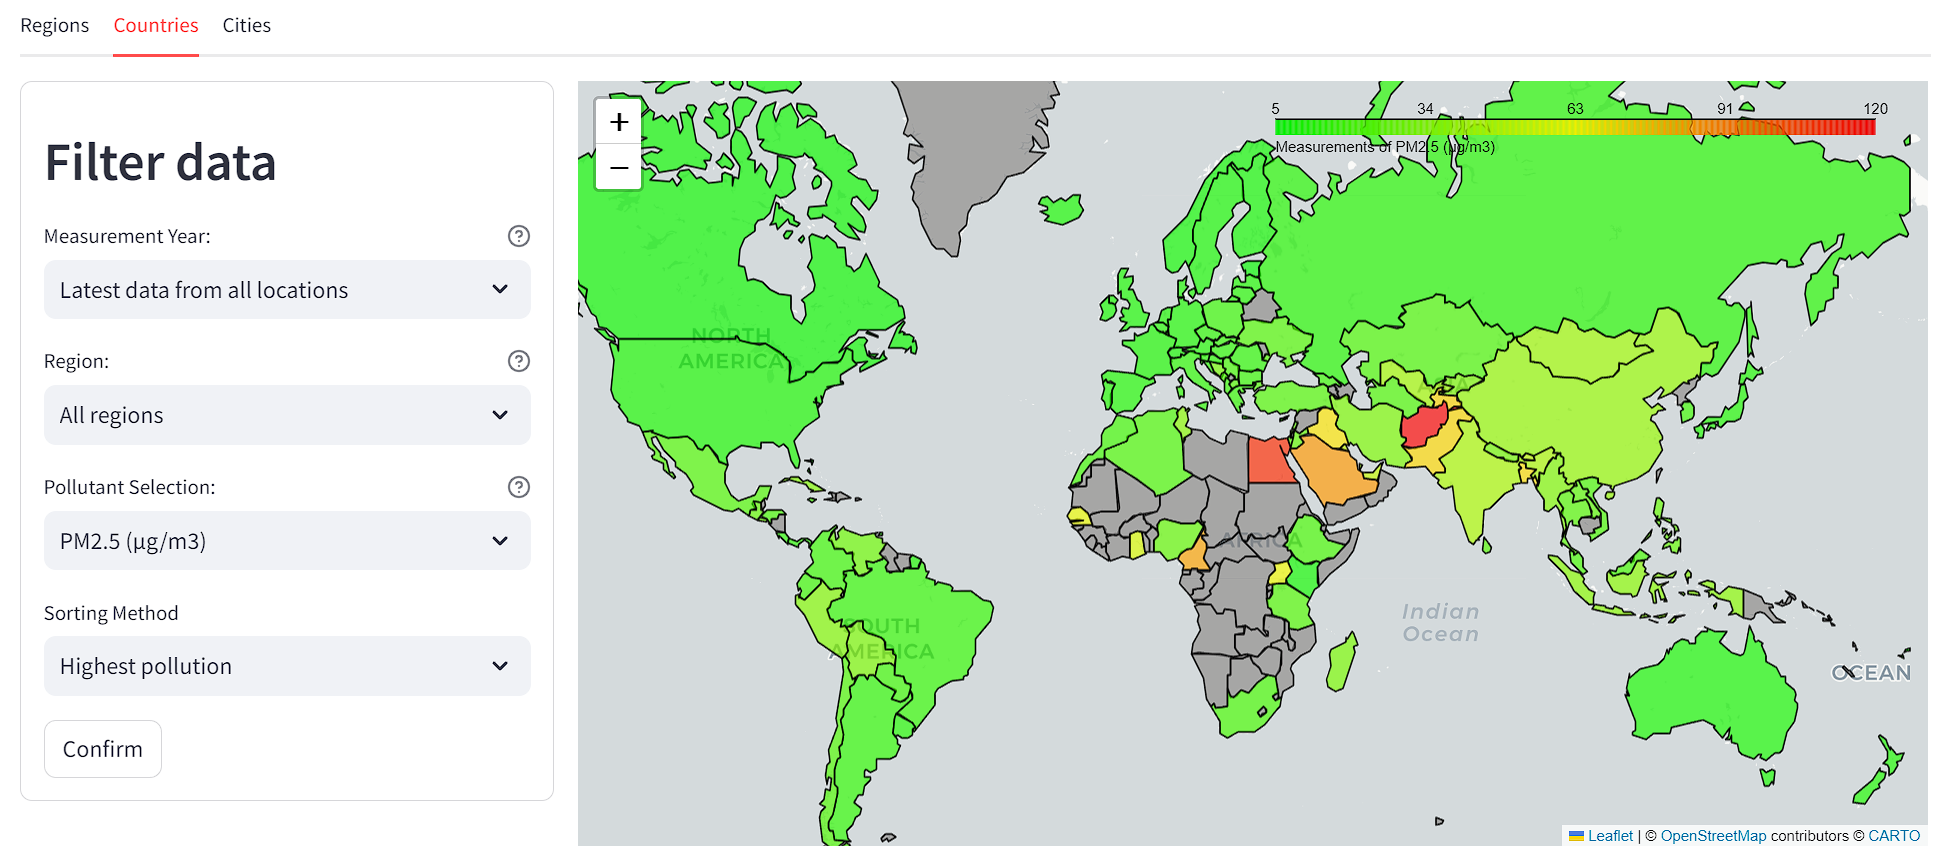

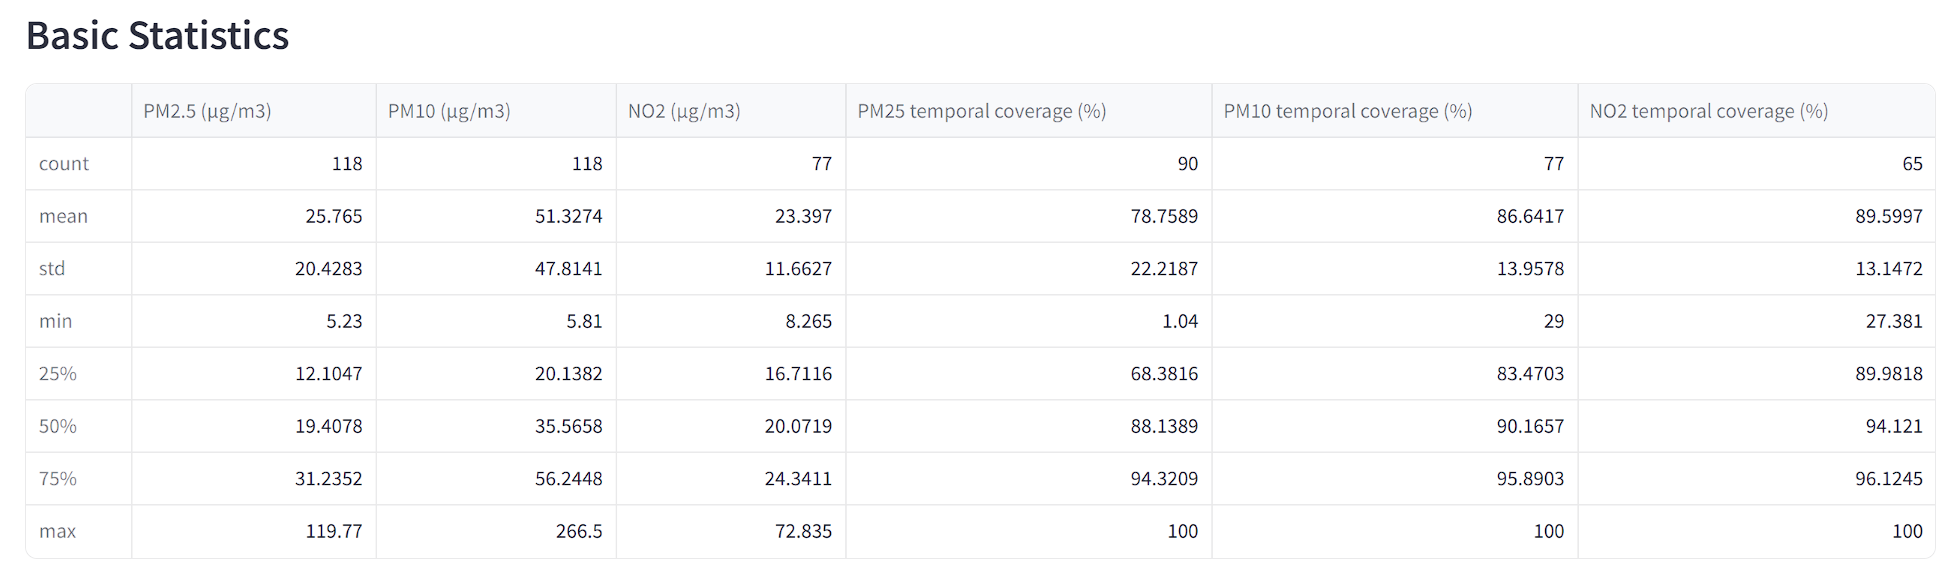

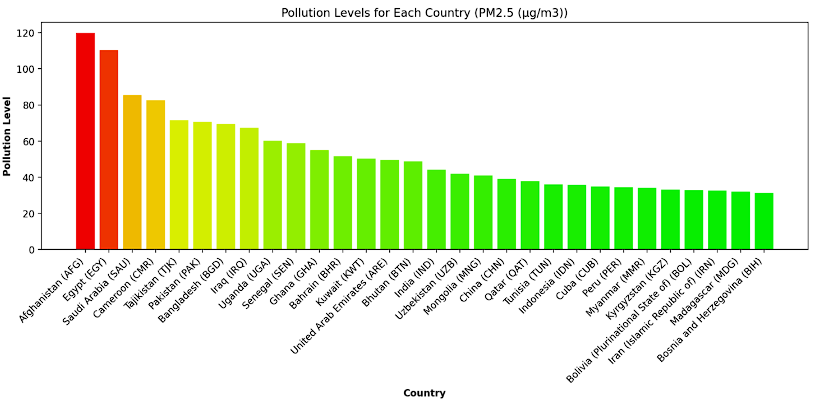

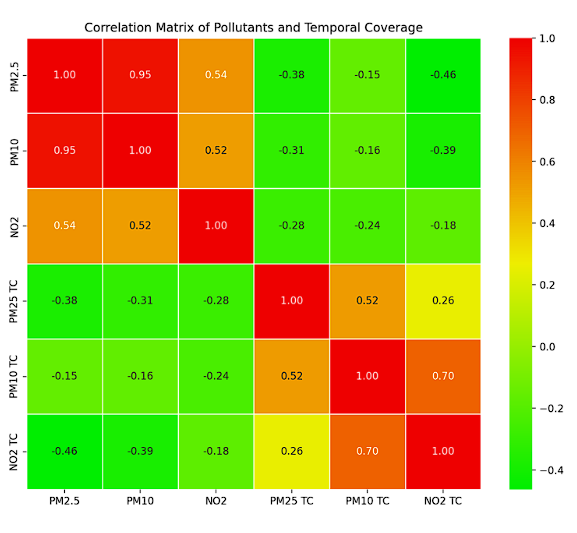


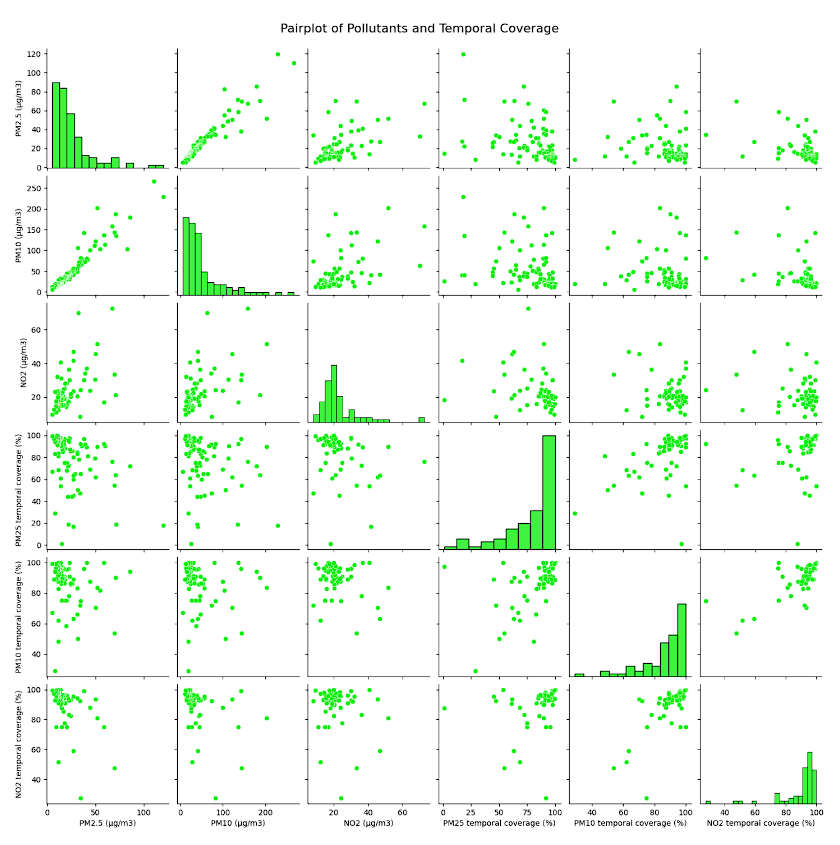

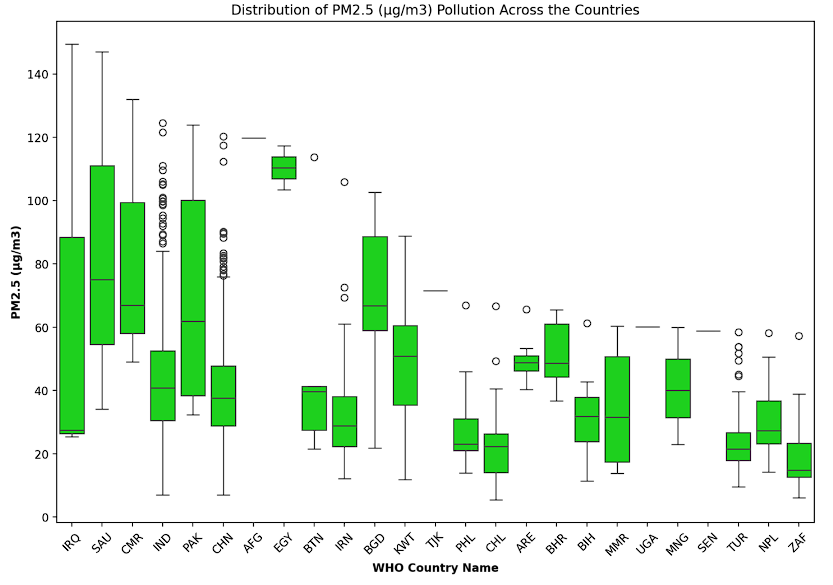

### Analiza krajów w danym regionie

Podobnie jak w analizie miast, można wykonać analizę krajów w obrębie danego regionu. Poniżej zamieszczono wyniki dla obu Ameryk, które w analizie dla wszystkich krajów były oznaczone praktycznie tym samym kolorem.

Najbardziej zanieczyszczonymi państwami okazały się Kuba, Peru oraz Boliwia. W Kubie wykonano jednakże tylko jeden pomiar, co świadczy o tym, że w analizie na poziomie krajów Kubę należałoby odrzucić.

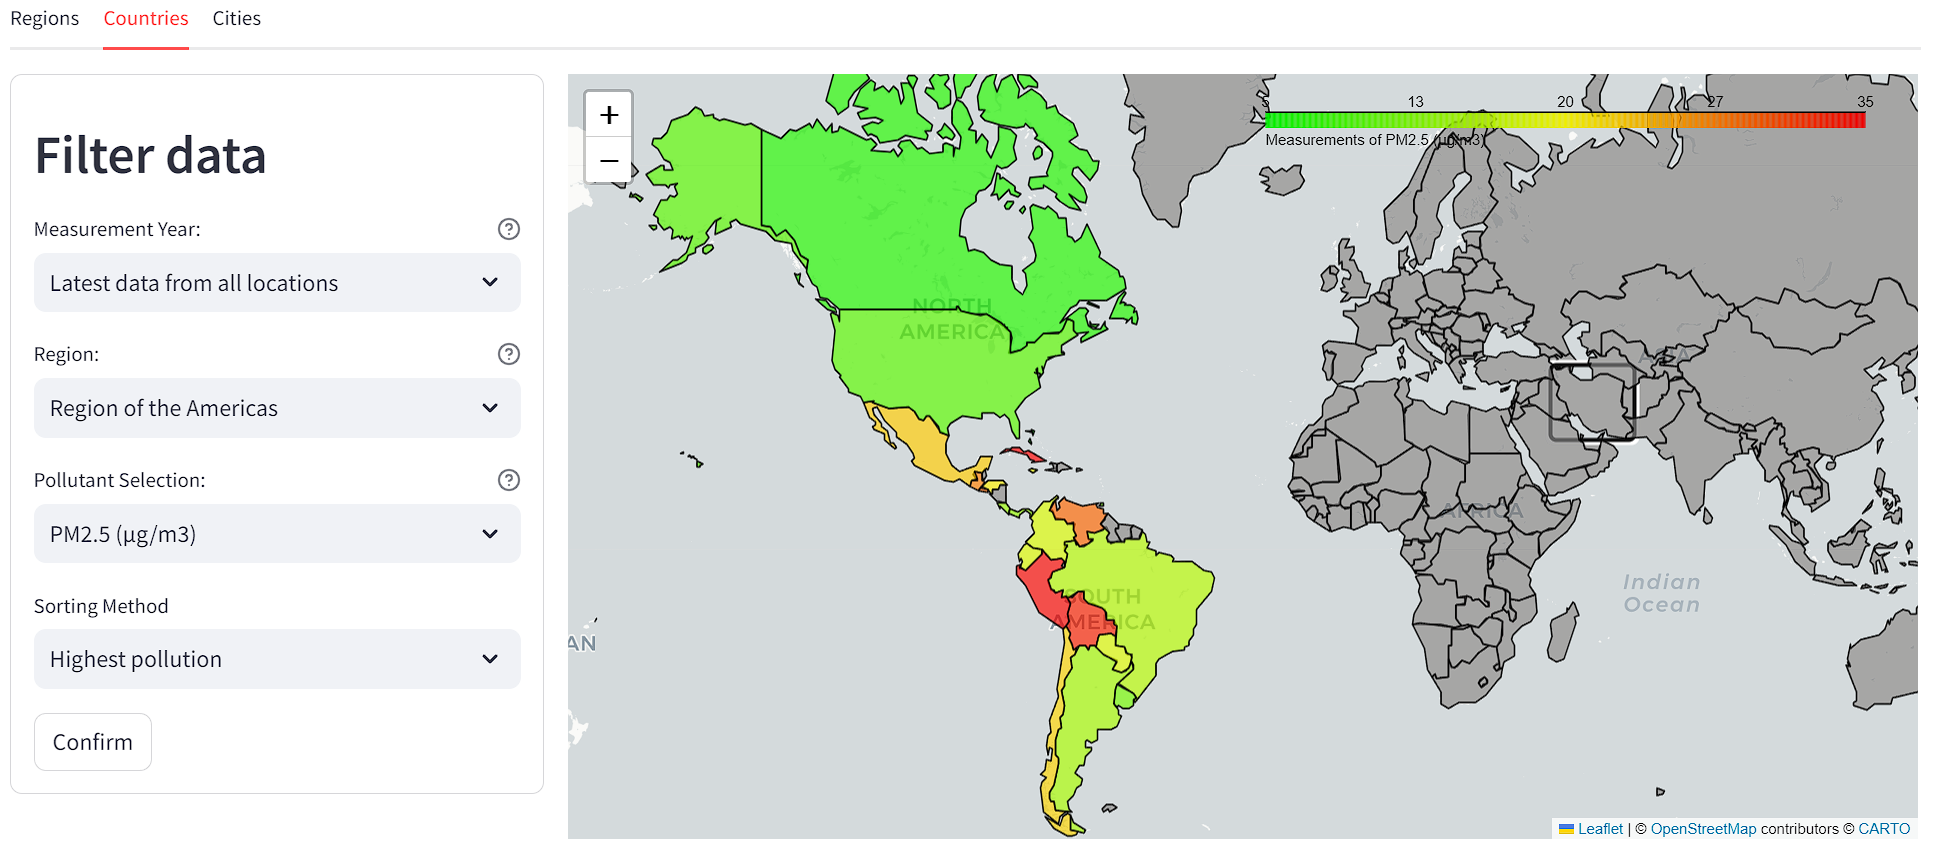

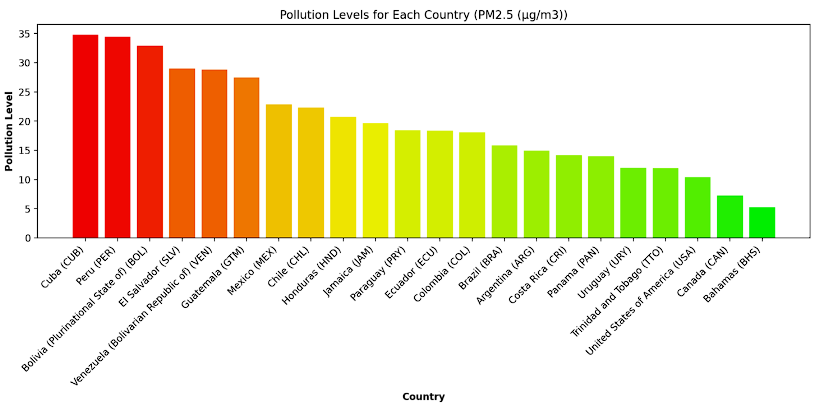

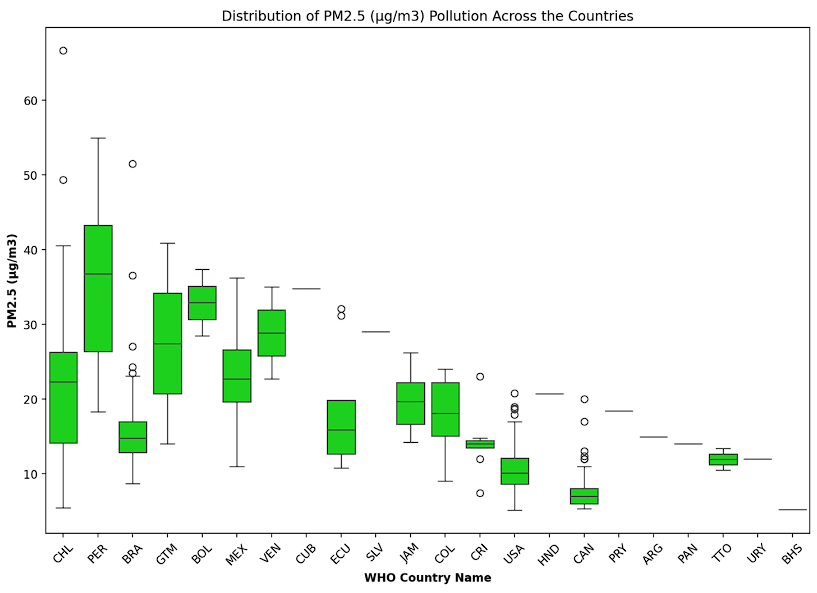

## Analiza dla regionów

W przypadku analizy dla regionów dostępnymi filtrami są: rok pomiaru oraz zmienna opisująca zanieczyszczenie. Na mapie przedstawiono średnie zanieczyszczenie PM2.5 obliczone dla najnowszych pomiarów ze wszystkich lokalizacji.

Azja Południowo-Wschodnia oraz wschodnia część Morza Śródziemnego to dwa najbardziej zanieczyszczone regiony. Może to wynikać z tego, że są to obszary rozwijające się, w których występują duże skupiska ludności oraz pojazdów. Wpływ na zanieczyszczenie mają także wykorzystanie paliw kopalnych oraz duża wilgotność powietrza.

Na poziomie regionów widać silną korelację między zanieczyszczeniem PM2.5, PM10 oraz NO2.

Na wykresie skrzynkowym można zaobserwować, że w przypadku Europy wystąpiły pomiary odstające. Jednym z nich jest pomiar z Tadżykistanu, który moim zdaniem został źle sklasyfikowany i powinien należeć do regionu wschodniej części Morza Śródziemnego.

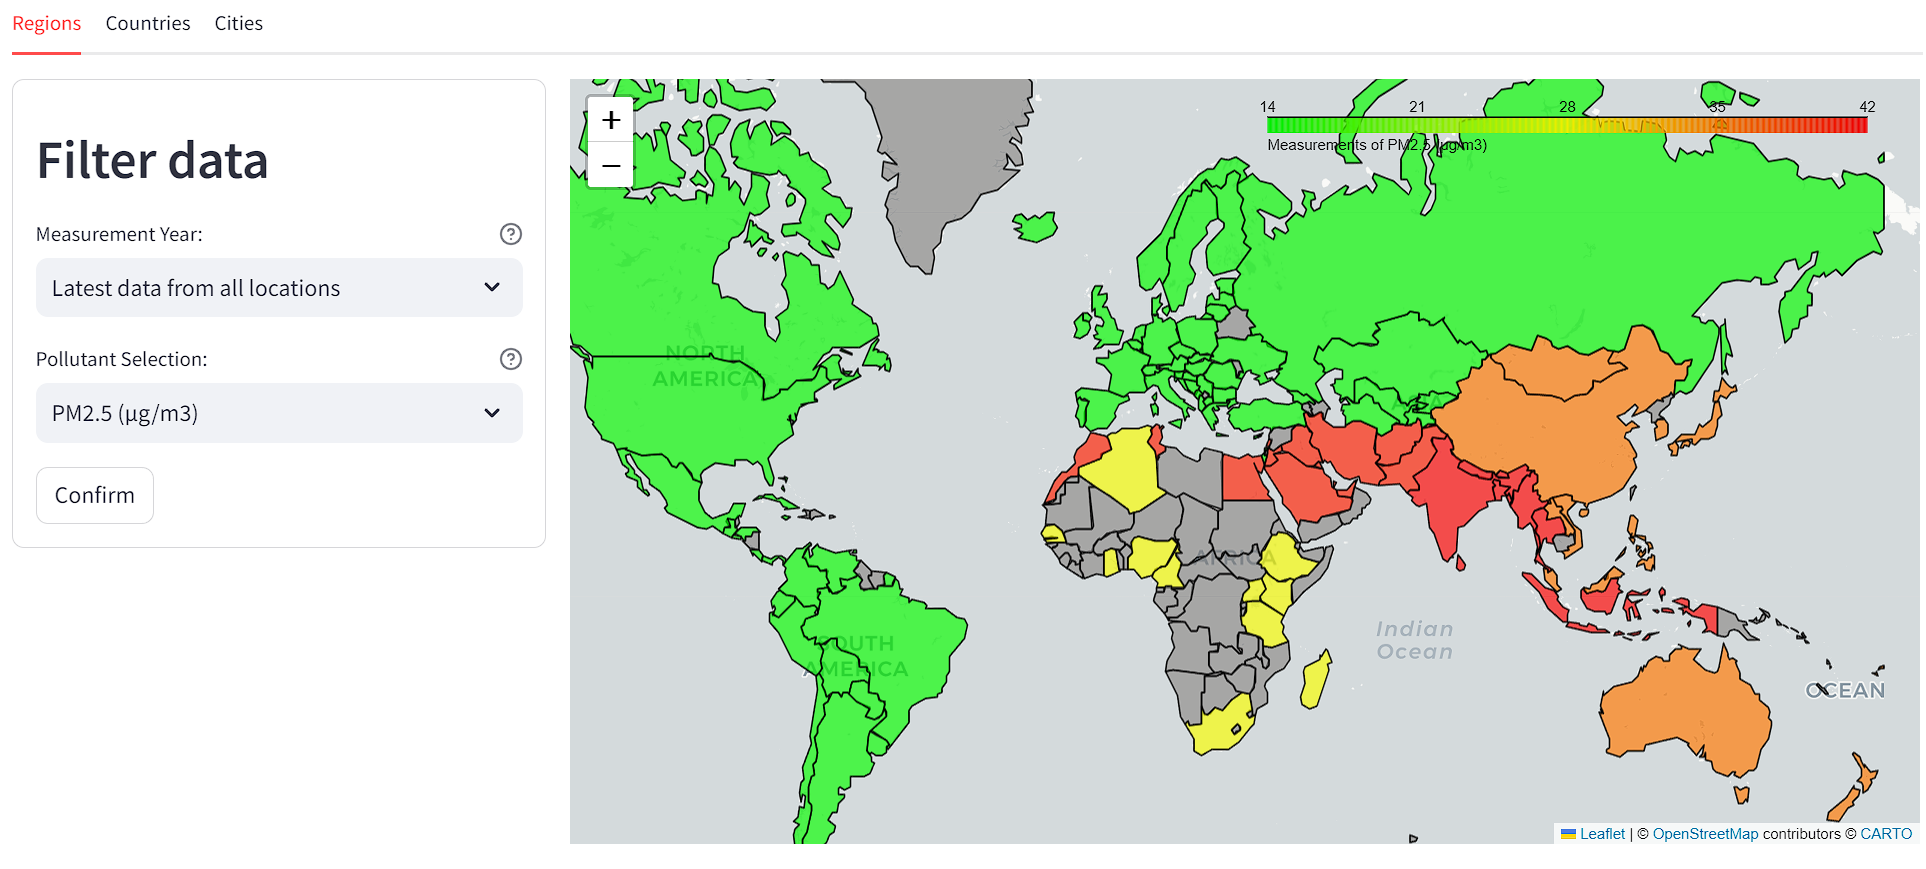

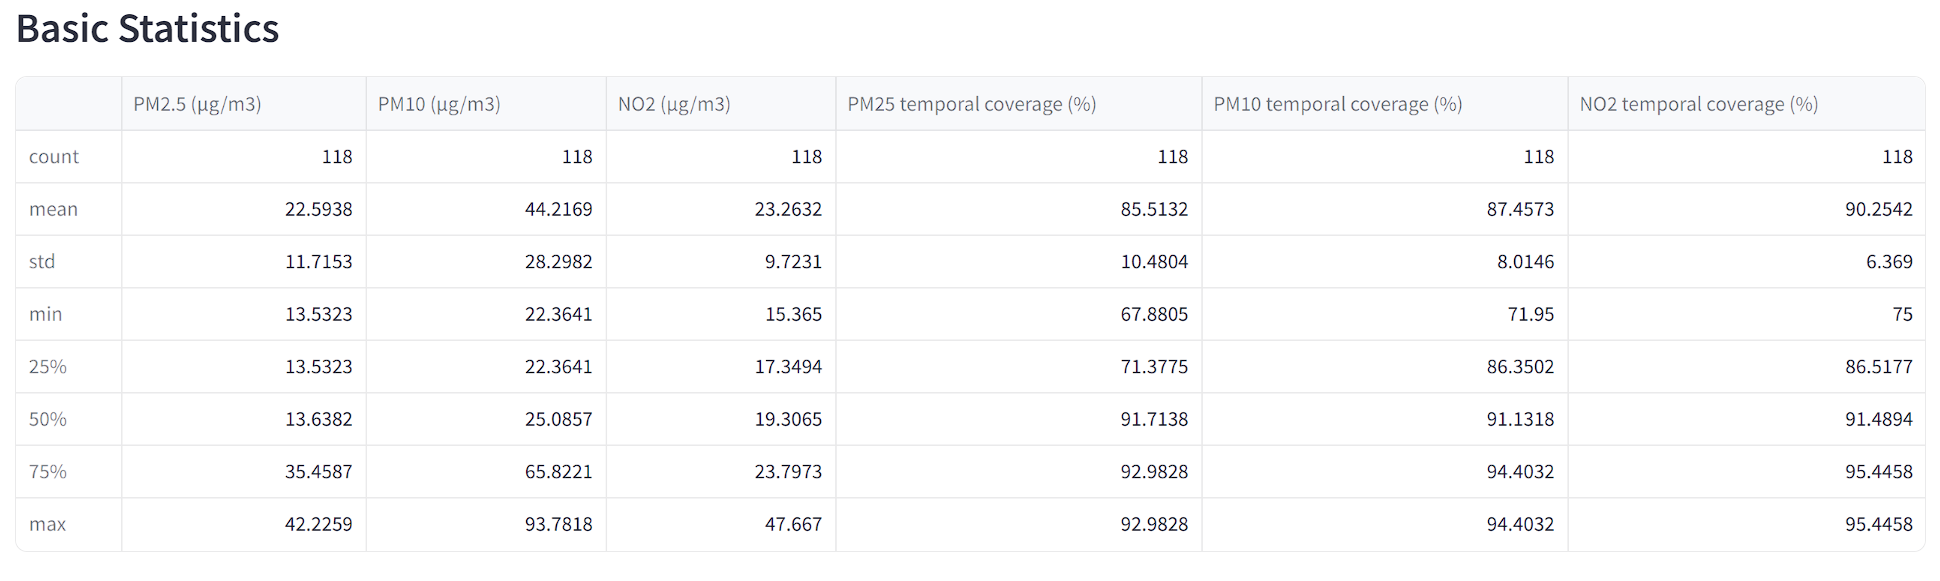

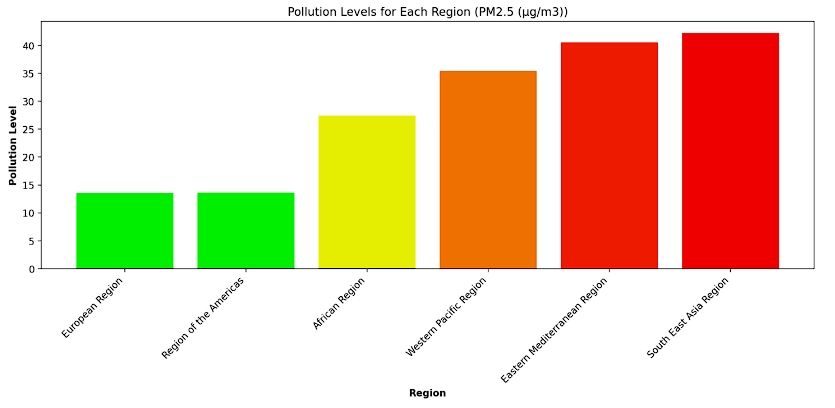

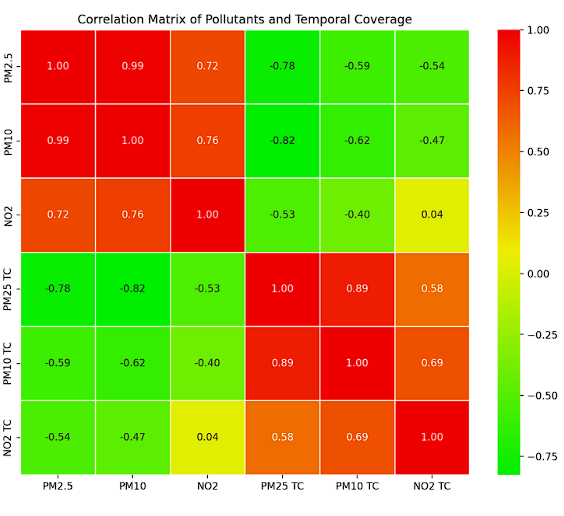

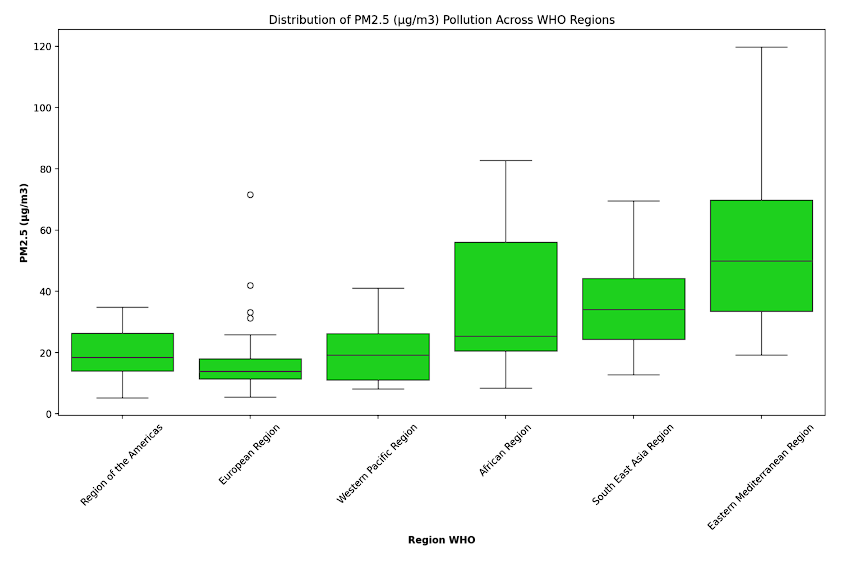

# Podsumowanie

Analiza danych dotyczących zanieczyszczenia powietrza przeprowadzona na różnych poziomach generalizacji (od regionów, poprzez kraje, aż po miasta) pozwoliła na wyciągnięcie istotnych wniosków dzięki wykorzystaniu technik takich jak boxploty, histogramy oraz macierze korelacji. Sporządzenie map do wizualizacji zanieczyszczenia w przestrzeni również umożliwiło lepsze zrozumienie rozkładu stężenia PM2.5, PM10 i NO2 w różnych obszarach świata. Na podstawie przeprowadzonej analizy można wysnuć następujące wnioski:

*  Zanieczyszczenie powietrza jest ściśle związane z działalnością przemysłową, stopniem industrializacji oraz urbanizacji, liczbą ludności, (a co za tym idzie - liczbą pojazdów).
*   Mapy geograficzne stanowią wartościowe narzędzie do wizualizacji przestrzennego rozkładu zanieczyszczenia powietrza. Pozwalają one na szybką identyfikację obszarów o wysokim stężeniu zanieczyszczeń.
*   Należy zastanowić się nad poprawnością wniosków wynikających z analizy na poziomie krajów. Ten stopień generalizacji nie jest odpowiedni dla państw o małej liczbie lokalizacji, w których przeprowadzane były pomiary, dlatego wyników tych nie można interpolować na cały obszar kraju.
*   Przed wykorzystaniem danych do dalszych celów należałoby usunąć punkty, w których ostatnie wykonane pomiary są nieaktualne. Na przykładzie miasta Bamenda w Kamerunie dobrze widać, że dane z 2012 roku mogą w znaczący sposób wpłynąć na analizę oraz interpretację wyników.


Dane dotyczące zanieczyszczenia powietrza mogą być bardzo użyteczne w uczeniu maszynowym, służąc jako dane wejściowe do modeli mających na celu przewidywanie jakości powietrza w przyszłości. Modele te mogą być wykorzystane do opracowywania strategii redukcji zanieczyszczeń oraz monitorowania skuteczności działań zmierzających do poprawy jakości powietrza.

Uważam, że aby taki model był użyteczny, należy ograniczyć modelowany obszar np. do poziomu państw. Zanieczyszczenie powietrza zależy od bardzo wielu czynników, dlatego model o większej generalizacji mógłby okazać się za ogólny, a przez to bezużyteczny. W bazie danych WHO brakuje bardzo wielu danych, szczególnie dotyczy to biednych krajów Afryki. Do stworzenia modelu UM na podstawie danych zanieczyszczenia należałoby zatem wykorzystać obszary, w których pomiary wykonywano w wielu miejscach oraz wielokrotnie na przestrzeni lat. W przyszłośći takim krajem mogłyby być np. Indie, w których liczba lokalizacji pomiarowych wynosi 407.
